In [1]:
from datasets import load_dataset

dataset = load_dataset("Skiittoo/cartoon-faces", split="train")

In [2]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from datasets import load_dataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),  
])

class CartoonFacesDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        img, caption = item['image'], item['text']
        
        # Convert RGBA to RGB if needed
        if img.mode == 'RGBA':
            img = img.convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        return img, caption

cartoon_dataset = CartoonFacesDataset(dataset, transform=transform)
dataloader = DataLoader(cartoon_dataset, batch_size=32, shuffle=True)

In [3]:
from torch import nn
class Encoder(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64, latent_channels=4):
        super().__init__()
        # Convolutional layers similar to before but designed to reduce spatial dims
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, 4, 2, 1)  # 64x64 -> 32x32
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels * 2, 4, 2, 1)  # 32x32 -> 16x16
        self.conv3 = nn.Conv2d(hidden_channels * 2, hidden_channels * 4, 4, 2, 1)  # 16x16 -> 8x8
        self.conv4 = nn.Conv2d(hidden_channels * 4, hidden_channels * 8, 4, 2, 1)  # 8x8 -> 4x4
        
        # Instead of flattening, output conv layers for mean and logvar
        self.conv_mean = nn.Conv2d(hidden_channels * 8, latent_channels, 3, 1, 1)
        self.conv_logvar = nn.Conv2d(hidden_channels * 8, latent_channels, 3, 1, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))  # [B, hidden_channels*8, 4, 4]
        
        mean = self.conv_mean(x)    # [B, latent_channels, 4, 4]
        log_var = self.conv_logvar(x)  # [B, latent_channels, 4, 4]
        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_channels=4, hidden_channels=64, out_channels=3):
        super().__init__()
        # Starting from spatial latent tensor
        self.deconv1 = nn.ConvTranspose2d(latent_channels, hidden_channels * 8, 4, 2, 1)  # 4x4 -> 8x8
        self.deconv2 = nn.ConvTranspose2d(hidden_channels * 8, hidden_channels * 4, 4, 2, 1)  # 8x8 -> 16x16
        self.deconv3 = nn.ConvTranspose2d(hidden_channels * 4, hidden_channels * 2, 4, 2, 1)  # 16x16 -> 32x32
        self.deconv4 = nn.ConvTranspose2d(hidden_channels * 2, out_channels, 4, 2, 1)  # 32x32 -> 64x64

    def forward(self, z):
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
        z = torch.sigmoid(self.deconv4(z))
        return z


class SpatialVAE(nn.Module):
    def __init__(self, latent_channels=4, hidden_channels=64, in_channels=3, out_channels=3):
        super().__init__()
        self.encoder = Encoder(in_channels, hidden_channels, latent_channels)
        self.decoder = Decoder(latent_channels, hidden_channels, out_channels)

    def forward(self, x):
        mean, log_var = self.encoder(x)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mean + eps * std  # reparameterization on spatial latents
        reconstructed = self.decoder(z)
        return reconstructed, mean, log_var


In [34]:
# import torch
# from torch import nn, optim
# from torch.utils.data import Dataset, DataLoader
# from PIL import Image
# from torchvision import transforms
# from datasets import load_dataset
# import matplotlib.pyplot as plt


# def vae_loss(recon, x, z_mean, z_log_var):
#     # Use BCE with logits if your decoder output is raw logits
#     # Otherwise, if you already apply Sigmoid at the output, use plain BCELoss
#     recon_loss = nn.functional.binary_cross_entropy(recon, x, reduction='sum')

#     kl_loss = -0.5 * torch.mean(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())  

#     return (recon_loss + kl_loss) / x.size(0)


# def show_reconstructions(vae, imgs, epoch, num=5, device='cuda'):
#     vae.eval()
#     imgs = imgs.to(device)
#     with torch.no_grad():
#         reconstructed, z_mean, z_log_var = vae(imgs)

#     imgs = imgs.detach().cpu()
#     reconstructed = reconstructed.detach().cpu()

#     # Plot side by side
#     fig, axs = plt.subplots(2, num, figsize=(2 * num, 4))
#     for i in range(num):
#         axs[0, i].imshow(imgs[i].permute(1, 2, 0).clip(0, 1))
#         axs[0, i].set_title("Original")
#         axs[0, i].axis("off")

#         axs[1, i].imshow(reconstructed[i].permute(1, 2, 0).clip(0, 1))
#         axs[1, i].set_title("Reconstructed")
#         axs[1, i].axis("off")

#     plt.suptitle(f"Reconstructions after epoch {epoch}")
#     plt.show()

# def train(vae, optimizer, epoch, loader, device='cuda'):
#     vae.train()
#     total_loss = 0

#     imgs_to_show = None
    
#     for imgs in loader:
#         imgs = imgs.to(device)
#         optimizer.zero_grad()
#         reconstructed, z_mean, z_log_var = vae(imgs)
#         loss = vae_loss(reconstructed, imgs, z_mean, z_log_var)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#         if imgs_to_show is None:
#             imgs_to_show = imgs.detach().cpu()

#     avg_loss = total_loss / len(loader.dataset)
#     print(f'Epoch {epoch} Loss {avg_loss}')

#     show_reconstructions(vae, imgs_to_show, epoch, num=5, device=device)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# vae = SpatialVAE()
# vae.to(device)
# # vae.load_state_dict(torch.load("/kaggle/working/vae_epoch30.pth", map_location=device))
# optimizer = optim.Adam(vae.parameters(), lr=1e-4)

# epochs = 50
# # go from 1,...,epochs+1
# for epoch in range(1, epochs+1):
#     train(vae, optimizer, epoch, dataloader, device)

#     # Save the model
#     torch.save(vae.state_dict(), f"spatial_vae_epoch{epoch}.pth")

# print("Training finished.")

In [35]:
# import torch
# import matplotlib.pyplot as plt
# import torch.nn.functional as F

# def show_reconstructions(originals, reconstructed, n=5):
#     originals = originals.detach().cpu().permute(0, 2, 3, 1)
#     reconstructed = reconstructed.detach().cpu().permute(0, 2, 3, 1)
#     fig, axs = plt.subplots(2, n, figsize=(2*n, 4))
#     for i in range(n):
#         axs[0, i].imshow(originals[i].clip(0, 1))
#         axs[0, i].axis("off")
#         axs[1, i].imshow(reconstructed[i].clip(0, 1))
#         axs[1, i].axis("off")
#     plt.suptitle("Top row: Original, Bottom row: Reconstructed")
#     plt.show()


# # Assuming you already have your VAE and DataLoader set up:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# vae = SpatialVAE()
# vae.to(device)
# vae.load_state_dict(torch.load("/kaggle/input/stable_vae/pytorch/default/1/spatial_vae_epoch50.pth", map_location=device))
# vae.eval()

# # Get the first batch from your DataLoader
# with torch.no_grad():
#     imgs = next(iter(dataloader))  # This gets first batch
#     imgs = imgs.to(device)
#     reconstructed, z_mean, z_log_var = vae(imgs)

# # Display side by side
# show_reconstructions(imgs, reconstructed)


# stable diffusion pipeline

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import torch.nn.functional as F

# Sinusoidal time embedding for diffusion timesteps
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, timesteps):
        """
        timesteps: (B,) long tensor of time step indices
        returns: (B, embedding_dim) float tensor of time embeddings
        """
        device = timesteps.device
        half_dim = self.embedding_dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = timesteps[:, None].float() * embeddings[None, :]  # (B, half_dim)
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# Small UNet model with time embeddings, adapted for latent space input
class UNetWithTimeEmbedding(nn.Module):
    def __init__(self,latent_channels,time_emb_dim=128,text_emb_dim=512):
        super().__init__()

        self.config = type('', (), {})()  # empty dummy config object
        self.config._diffusers_version = "0.9.0"
    
        self.text_proj = nn.Sequential(
            nn.Linear(text_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        self.time_embedding = SinusoidalPositionEmbeddings(time_emb_dim)

        # Map time embeddings to a vector for conditional modulation
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 2),
            nn.ReLU(),
            nn.Linear(time_emb_dim * 2, time_emb_dim),
        )

        # Encoder conv blocks
        self.encoder1 = nn.Sequential(
            nn.Conv2d(latent_channels, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
        )

        # Decoder conv blocks
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
        )

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
        )

        # Final conv layer to predict noise
        self.final_conv = nn.Conv2d(64, latent_channels, 1)

        # To condition conv layers on time embeddings (simple way: add after each block)
        self.time_emb_proj1 = nn.Linear(time_emb_dim, 64)
        self.time_emb_proj2 = nn.Linear(time_emb_dim, 128)
        self.time_emb_proj_bottleneck = nn.Linear(time_emb_dim, 256)

    def forward(self, x, t, text=None):
        # t emb
        t_emb = self.time_embedding(t)  # (B, time_emb_dim)
        t_emb = self.time_mlp(t_emb)     # (B, time_emb_dim)
    
        if text is not None:
            text = self.text_proj(text)  # (B, time_emb_dim)
            t_emb = t_emb + text

        # Encoder 1
        x1 = self.encoder1(x)  # (B,64,H,W)
        # Add time embedding as bias broadcasted to channels & spatial dims
        x1 = x1 + self.time_emb_proj1(t_emb)[:, :, None, None]
        p1 = self.pool1(x1)

        # Encoder 2
        x2 = self.encoder2(p1)  # (B,128,H/2,W/2)
        x2 = x2 + self.time_emb_proj2(t_emb)[:, :, None, None]
        p2 = self.pool2(x2)

        # Bottleneck
        b = self.bottleneck(p2)  # (B,256,H/4,W/4)
        b = b + self.time_emb_proj_bottleneck(t_emb)[:, :, None, None]

        # Decoder 2
        up2 = self.up2(b)
        concat2 = torch.cat([up2, x2], dim=1)
        d2 = self.decoder2(concat2)

        # Decoder 1
        up1 = self.up1(d2)
        concat1 = torch.cat([up1, x1], dim=1)
        d1 = self.decoder1(concat1)

        return self.final_conv(d1)


import torch

def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    """
    Linear schedule for betas.
    """
    return torch.linspace(beta_start, beta_end, timesteps)

def forward_diffusion_process(x0, t, beta_schedule):
    beta = beta_schedule.to(x0.device)
    alpha = 1 - beta
    alpha_cumprod = torch.cumprod(alpha, dim=0)

    # Debug prints
    a_cumprod_t = alpha_cumprod[t].view(-1, 1, 1, 1)
    a_cumprod_t = torch.clamp(a_cumprod_t, min=1e-8, max=1.0)
    a_sqrts = torch.sqrt(a_cumprod_t)

    one_minus_cumprod_t = 1 - a_cumprod_t
    one_minus_cumprod_t = torch.clamp(one_minus_cumprod_t, min=1e-8, max=1.0)
    one_minus_sqrts = torch.sqrt(one_minus_cumprod_t)

    epsilon = torch.randn_like(x0)

    noisy = a_sqrts * x0 + one_minus_sqrts * epsilon
    return noisy, epsilon

In [ ]:
import torch 
from transformers import CLIPProcessor, CLIPModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = SpatialVAE()
vae.to(device)
vae.load_state_dict(torch.load("/kaggle/input/stable_vae/pytorch/default/1/spatial_vae_epoch50.pth", map_location=device))
vae.eval()

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.to(device)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
timesteps = 1000
epochs = 15
lr = 2e-4
latent_channels = 4  # your VAE latent channel dimension

beta_schedule = linear_beta_schedule(timesteps).to(device)
alpha = 1 - beta_schedule
alpha_cumprod = torch.cumprod(alpha, dim=0)
alpha_cumprod_prev = torch.cat([torch.ones(1, device=device), alpha_cumprod[:-1]])

model = UNetWithTimeEmbedding(latent_channels=latent_channels).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    
    for images, captions in dataloader:  
        images = images.to(device)
        batch_size = images.shape[0]

        inputs = clip_processor(
            images=images,
            text=captions,
            return_tensors='pt',
            padding=True,
            truncation=True,
            do_rescale=False  # set depending on your image dtype
        )
        
        # Move all inputs to the correct device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Extract only the text inputs needed for clip_model.text_model()
        text_inputs = {
            "input_ids": inputs["input_ids"],
            "attention_mask": inputs["attention_mask"]
        }
        
        with torch.no_grad():
            text_outputs = clip_model.text_model(**text_inputs)
            text_features = text_outputs.pooler_output

        # Encode images with VAE (no grad)
        with torch.no_grad():
            mu, log_var = vae.encoder(images)
            var = torch.exp(log_var).clamp(min=1e-6)
            std = var.sqrt()
            latents = mu + std * torch.randn_like(std)

        # Sample diffusion timestep for each sample in batch
        t = torch.randint(0, timesteps, (batch_size,), device=device)

        # Forward diffusion step: add noise
        noisy_latents, noise = forward_diffusion_process(latents, t, beta_schedule)

        # Predict noise with UNet conditioned on text embeddings
        noise_pred = model(noisy_latents, t, text=text_features)

        loss = criterion(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(dataloader):.6f}")

torch.save(model.state_dict(), "unet_weights.pth")

KeyboardInterrupt: 

# inference

In [ ]:
# import torch 
# from transformers import CLIPProcessor, CLIPModel

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# unet = UNetWithTimeEmbedding(latent_channels=4)
# unet.to(device)
# unet.load_state_dict(torch.load("/kaggle/input/unet_model/pytorch/default/1/unet_weights.pth", map_location=device))
# unet.eval()

# vae = SpatialVAE()
# vae.to(device)
# vae.load_state_dict(torch.load("/kaggle/input/stable_vae/pytorch/default/1/spatial_vae_epoch50.pth", map_location=device))
# vae.eval()

# clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
# clip_model.to(device)

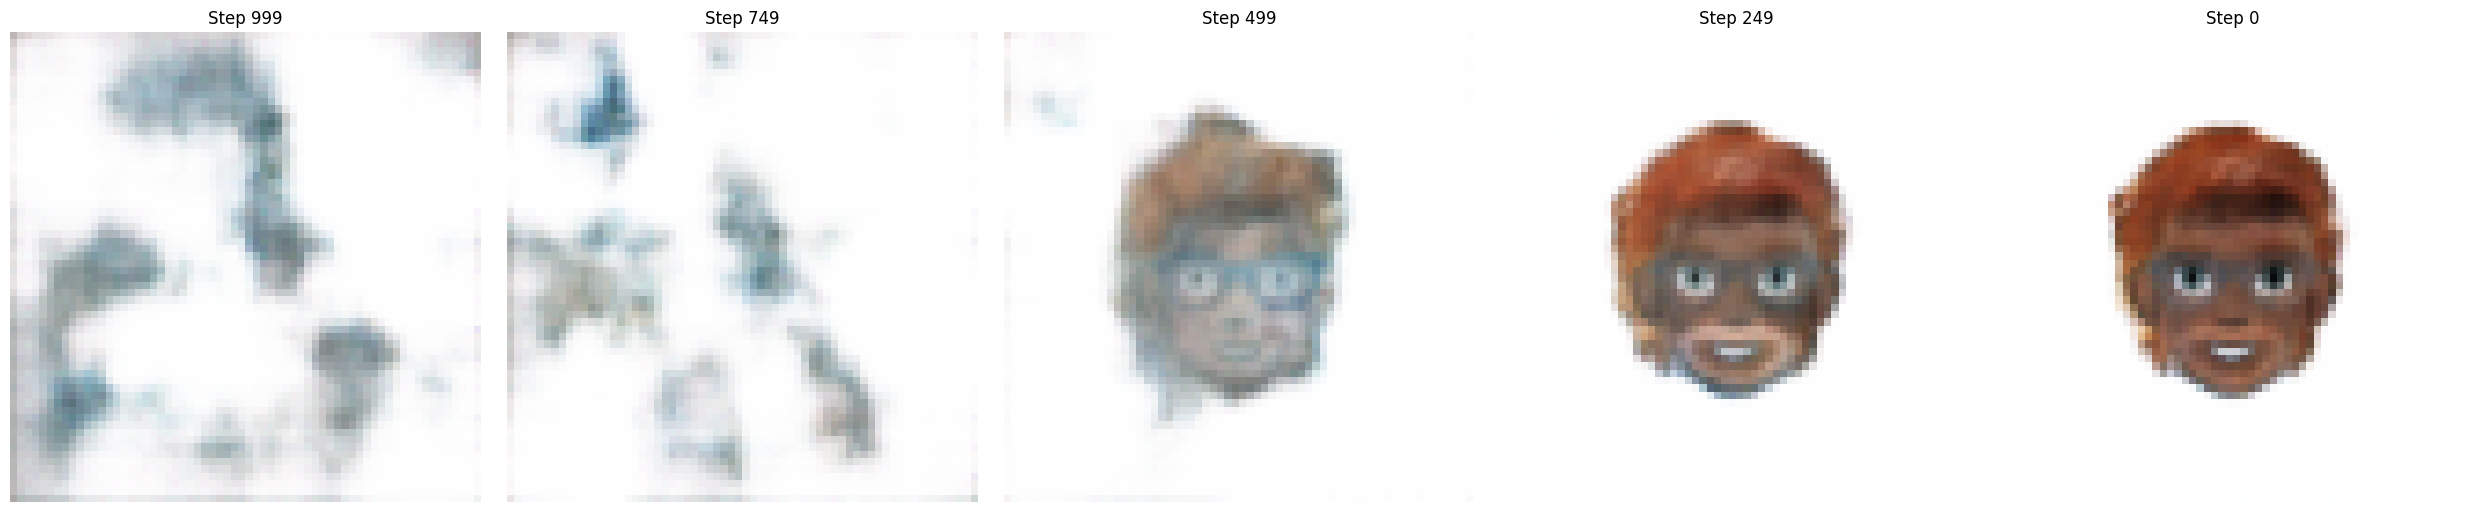

In [35]:
# import torch
# import matplotlib.pyplot as plt

# @torch.no_grad()
# def generate_image_from_text(prompt, model, vae, clip_model, clip_processor,
#                              timesteps, beta_schedule, latent_channels,
#                              height, width, device,
#                              view_steps=[999, 749, 499, 249, 0],
#                              batch_size=1):

#     model.eval()
#     vae.eval()
#     clip_model.eval()

#     beta_schedule = beta_schedule.to(device)
#     alpha = 1 - beta_schedule
#     alpha_cumprod = torch.cumprod(alpha, dim=0)
#     alpha_cumprod_prev = torch.cat([torch.ones((1,), device=device), alpha_cumprod[:-1]], dim=0)

#     # Process the prompt into text embeddings once
#     inputs = clip_processor(text=[prompt], return_tensors="pt", padding=True, truncation=True)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
    
#     with torch.no_grad():
#         text_outputs = clip_model.text_model(**inputs)
#         text_features = text_outputs.pooler_output  # shape: (1, hidden_dim)
    
#     # Start from pure noise at the last timestep
#     x_t = torch.randn((batch_size, latent_channels, height, width), device=device)

#     imgs = {}

#     for t in reversed(range(timesteps)):
#         t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.long)

#         # Predict noise at current timestep using the model (UNet), conditioning on text embeddings
#         noise_pred = model(x_t, t_tensor, text=text_features)

#         alpha_t = alpha[t]
#         alpha_cumprod_t = alpha_cumprod[t]
#         alpha_cumprod_prev_t = alpha_cumprod_prev[t]
#         beta_t = beta_schedule[t]

#         coef1 = 1 / torch.sqrt(alpha_t)
#         coef2 = beta_t / torch.sqrt(1 - alpha_cumprod_t)
#         mean = coef1 * (x_t - coef2 * noise_pred)

#         if t > 0:
#             noise = torch.randn_like(x_t)
#             sigma_t = torch.sqrt(beta_t)
#             x_t = mean + sigma_t * noise
#         else:
#             x_t = mean

#         # Save reconstructed images at the requested timesteps
#         if t in view_steps:
#             with torch.no_grad():
#                 reconstructed = vae.decoder(x_t).clamp(0, 1).cpu()[0].permute(1, 2, 0).numpy()
#             imgs[t] = reconstructed

#     # Plot snapshots
#     num_steps = len(view_steps)
#     fig, axs = plt.subplots(1, num_steps, figsize=(5 * num_steps, 5))
#     if num_steps == 1:
#         axs = [axs]

#     for i, t in enumerate(view_steps):
#         axs[i].imshow(imgs[t])
#         axs[i].set_title(f"Step {t}")
#         axs[i].axis('off')

#     plt.tight_layout()
#     plt.show()


# # Usage example:
# prompt = "Cartoon face with brown hair and black skin"
# generate_image_from_text(prompt, unet, vae, clip_model, clip_processor,
#                          timesteps=1000, beta_schedule=beta_schedule,
#                          latent_channels=4, height=4, width=4, device=device)
